# Bandit Agents Library (A concise and easy to use library to help with k-armed bandit problems)
This library is an attempt at creating a library that would streamline the resolution of k-armed bandit problems

It was mostly inspired by the first few chapters of [Reinforcement Learning: An Introduction](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)

## installation
There are a few ways to install the library

* pip: `pip install https://github.com/The-Faust/bandit_agents`
* local: clone or download a release of the library and add it to your python path

Note: Once I have a decent documentation going on I intend on putting the library in pypi and conda-forge

### development installation
If you intend on forking the project or you are a contributor working with me you will have to setup the development environment

#### requirements for installation of the dev env
To make use of the setup script you must have anaconda3 installed and have conda-lock installed in the environment in which you will execute [setup_dev_env.sh](https://github.com/The-Faust/bandit_agents/blob/master/setup_dev_env.sh)

#### setup script
to execute the setup script execute the following
```
chmod +x setup_dev_env.sh
./setup_dev_env.sh
```

executing [setup_dev_env.sh](https://github.com/The-Faust/bandit_agents/blob/master/setup_dev_env.sh) will do the following:
1. give the roght permissions to [build_env.sh](https://github.com/The-Faust/bandit_agents/blob/master/build_env.sh) and [compile_env_lock.sh](https://github.com/The-Faust/bandit_agents/blob/master/compile_env_lock.sh)
2. if lock file does not exists; execute [compile_env_lock.sh](https://github.com/The-Faust/bandit_agents/blob/master/compile_env_lock.sh)
3. create the conda environement by executing [build_env.sh](https://github.com/The-Faust/bandit_agents/blob/master/build_env.sh)
4. install the pre-commit hooks found in [.pre-commit-config.yaml](https://github.com/The-Faust/bandit_agents/blob/master/.pre-commit-config.yaml)

You can then activate the environement in conda: `conda activate bandit_agent_dev_env`

## Exemples
I made a few exemples that can teach you the basics as to how to use the library

all exemples can be found in the [Exemples](https://github.com/The-Faust/bandit_agents/tree/master/Exemples) folder of the project

### Simulations
The simulations exemples are to help you develop an intuitive understanding of how the solvers perform depending on the context in which you put them

#### Basic simulations
[Basic simulations](https://github.com/The-Faust/bandit_agents/tree/master/Exemples/basic_exemples) are simply to show the performance of different solvers givent a very simple context

[The basic simulations](https://github.com/The-Faust/bandit_agents/tree/master/Exemples/basic_exemples) exemples are as follow
* [weight_solver_exemple](https://github.com/The-Faust/bandit_agents/blob/master/Exemples/basic_exemples/weight_solver_example.py)
* [epsilon_solver_exemple](https://github.com/The-Faust/bandit_agents/blob/master/Exemples/basic_exemples/epsilon_solver_example.py)
* [ucb_solver_exemple](https://github.com/The-Faust/bandit_agents/blob/master/Exemples/basic_exemples/ucb_solver_example.py)
* [sampling_solver_exemple](https://github.com/The-Faust/bandit_agents/blob/master/Exemples/basic_exemples/sampling_solver_example.py)

### agents
[Agents exemples](https://github.com/The-Faust/bandit_agents/tree/master/Exemples/agents_exemples) are designed to show you the intended usage for the library

[The agent exemples](https://github.com/The-Faust/bandit_agents/tree/master/Exemples/agents_exemples) are as follow"
* [basic_agent_exemple](https://github.com/The-Faust/bandit_agents/blob/master/Exemples/agents_exemples/basic_agent_exemple.py)

## An actual exemple
Following is a simplified version of the [basic agent exemple](https://github.com/The-Faust/bandit_agents/blob/master/Exemples/agents_exemples/basic_agent_exemple.py) with more comment

Say we have two possible pseudo-random actions defined by func_a and func_b
```python3
def func_a(): float:
    return gamma.rvs(a=6.8, scale=0.1, loc=0, size=1)[0] # A mystery number

def func_b(): float:
    return gamma.rvs(a=2.2, scale=0.2, loc=0, size=1)[0] # A mystery number
```

for this exemple we will assume that we don't really know which of the action is better. We want to find out which action will return the best reward.

If we were to try and find that out by ourselves without any tool or help we'd have to execute the actions a few times and then remember which one tended to wield the best score after a few executions, then we would assume that said action is the "best" and exploit it by only calling it for a while. If after a while we doubt that the action we found is still best we would have to start that process all over again. 

The purpose of Bandit Agents library is to automate that process, using different strategies that wield varying degrees of success given a few different contexts.

Let's continue our exemple; To exploit the best action we instanciate an agent with our mystery functions
```python3
action_a = ('action_a', func_a)
action_b = ('action_b', func_b)

actions = (action_a, action_b)

agent = Agent(actions)
```
We now have our agent, the agent is the object that will exploreand exploit our actions and will attemp to wield the best possible reward

Say we want the agent to work for a 100 epochs in which it will explore and exploit the actions we gave it, we would do that with the following code
```python3
for i in range(100):
    indexes, targets = agent.act()
    agent = agent.fit(x=indexes, y=targets)
```

If we want to see which action worked best, we can loog at the weights returned by the agent
```python3
print(agent.info())
```

Here is the complete example without interruption
```python3
from BanditAgents import Agent
from scipy.stats import gamma

def func_a(): float:
    return gamma.rvs(a=6.8, scale=0.1, loc=0, size=1)[0] # A mystery number

def func_b(): float:
    return gamma.rvs(a=2.2, scale=0.2, loc=0, size=1)[0] # A mystery number

action_a = ('action_a', func_a)
action_b = ('action_b', func_b)

actions = (action_a, action_b)

agent = Agent(actions)

for i in range(100):
    indexes, targets = agent.act()
    agent = agent.fit(x=indexes, y=targets)

print(agent.info())
```

## Run exemples via the terminal
You can run all the exemples via the terminal. To do so go into the project's folder and run
`python3 -m . -e basic` for the basic exemples and `python3 -m . -e agents` to run the agents exemples.

### performances

There are many more options you can use in the library to solve your problems depending on your needs and I hope you will install it and use it for your projects.

## Solver examples rundown

This notebook is intended to demonstrate how to use the BanditSolvers library and to hopefully convince you of its efficacy when solving k-armed bandit problems.

## Basic simulations
This first part is intended as a summary analysis of the basic examples simulations.
The functions it runs are meant to be the basic examples that should be studied to understand how to use the library

### Methodology
The methodology for this simulation is as follow:
* for each solver a simulation is run
* each solver simulation is independent of the others
* the target are generated from 2 gamma distributions that are sampled each time its associated action is called
* For each simulation the parameters for the gamma distributions are the same
* The parameters of each solver are the same except for the unique parameters associated with each type

The solvers parameters are as follow:
```[python3]
    # General params
    optimistic_value=5.
    step_size=1e-2

    # epsilon
    epsilon=1e-2

    # ucb
    confidence=1e-2
```

#### Actions analysis
The gamma distributions parameters are as follow:
```
    # action_a
    alpha=0.5
    loc=0
    scale=1

    # action_b
    alpha=0.1
    loc=0
    scale=1
```
Which yields the following density functions

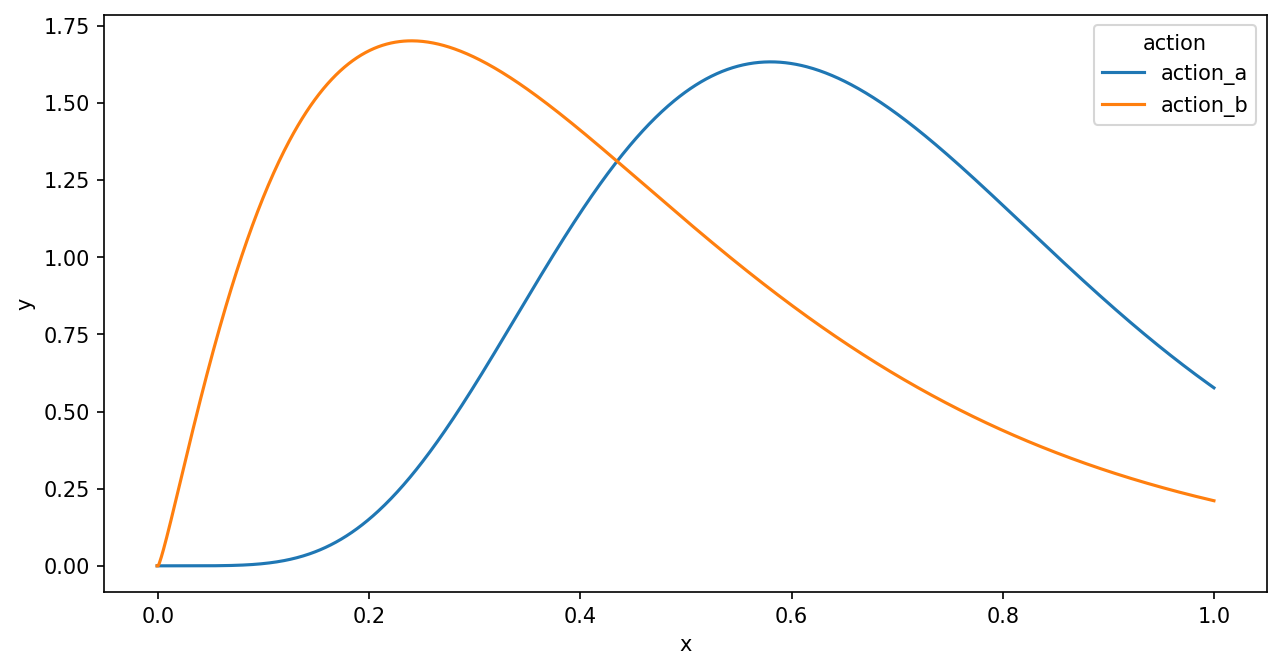

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import DataFrame, concat
from scipy.stats import gamma

x = np.linspace(-0.001, 1, 1000)

action_a_y = gamma.pdf(x, a=6.8, scale=0.1, loc=0)
action_b_y = gamma.pdf(x, a=2.2, scale=0.2, loc=0)

action_a_pdf_df = DataFrame({
    'x': x,
    'y': action_a_y,
    'action': 'action_a'
})

action_b_pdf_df = DataFrame({
    'x': x,
    'y': action_b_y,
    'action': 'action_b'
})

actions_pdf_df = concat([action_a_pdf_df, action_b_pdf_df])

plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] =150
plt.figure(figsize=(10, 5))

f = sns.lineplot(actions_pdf_df, x='x', y='y', hue='action')

Thanks to this graphic we see that of our two actions the clear winner is action_a, But there is still a decent overlap in the values that can be returned between the actions, which could lead to some confusion if we were to try and solve the problem manually

### Basic Simulation execution

In [20]:
from pandas import DataFrame
from Exemples.basic_exemples import run_basic_examples

base_examples_df: DataFrame = run_basic_examples()
base_examples_df

,steps,action_indexes,action_keys,targets,simulation
0,0,1,action_b,0.482348,weighted
1,1,1,action_b,0.330937,weighted
2,2,0,action_a,0.614899,weighted
3,3,0,action_a,0.747402,weighted
4,4,0,action_a,0.875793,weighted
...,...,...,...,...,...
95,95,0,action_a,1.054156,sampling
96,96,1,action_b,0.149921,sampling
97,97,1,action_b,0.465692,sampling
98,98,0,action_a,0.805536,sampling


As can be seen the result of this execution is a dataframe in which each row represents a decision.

Each row contains: 
* the step at which the decision was take
* the decision taken
* its associated target
* the solver that was used to take the decision

To illustrate that it might be hard to interpret the data based only on the resulting targets of the actions here is a plot of the targets obtained after each solver's decisions

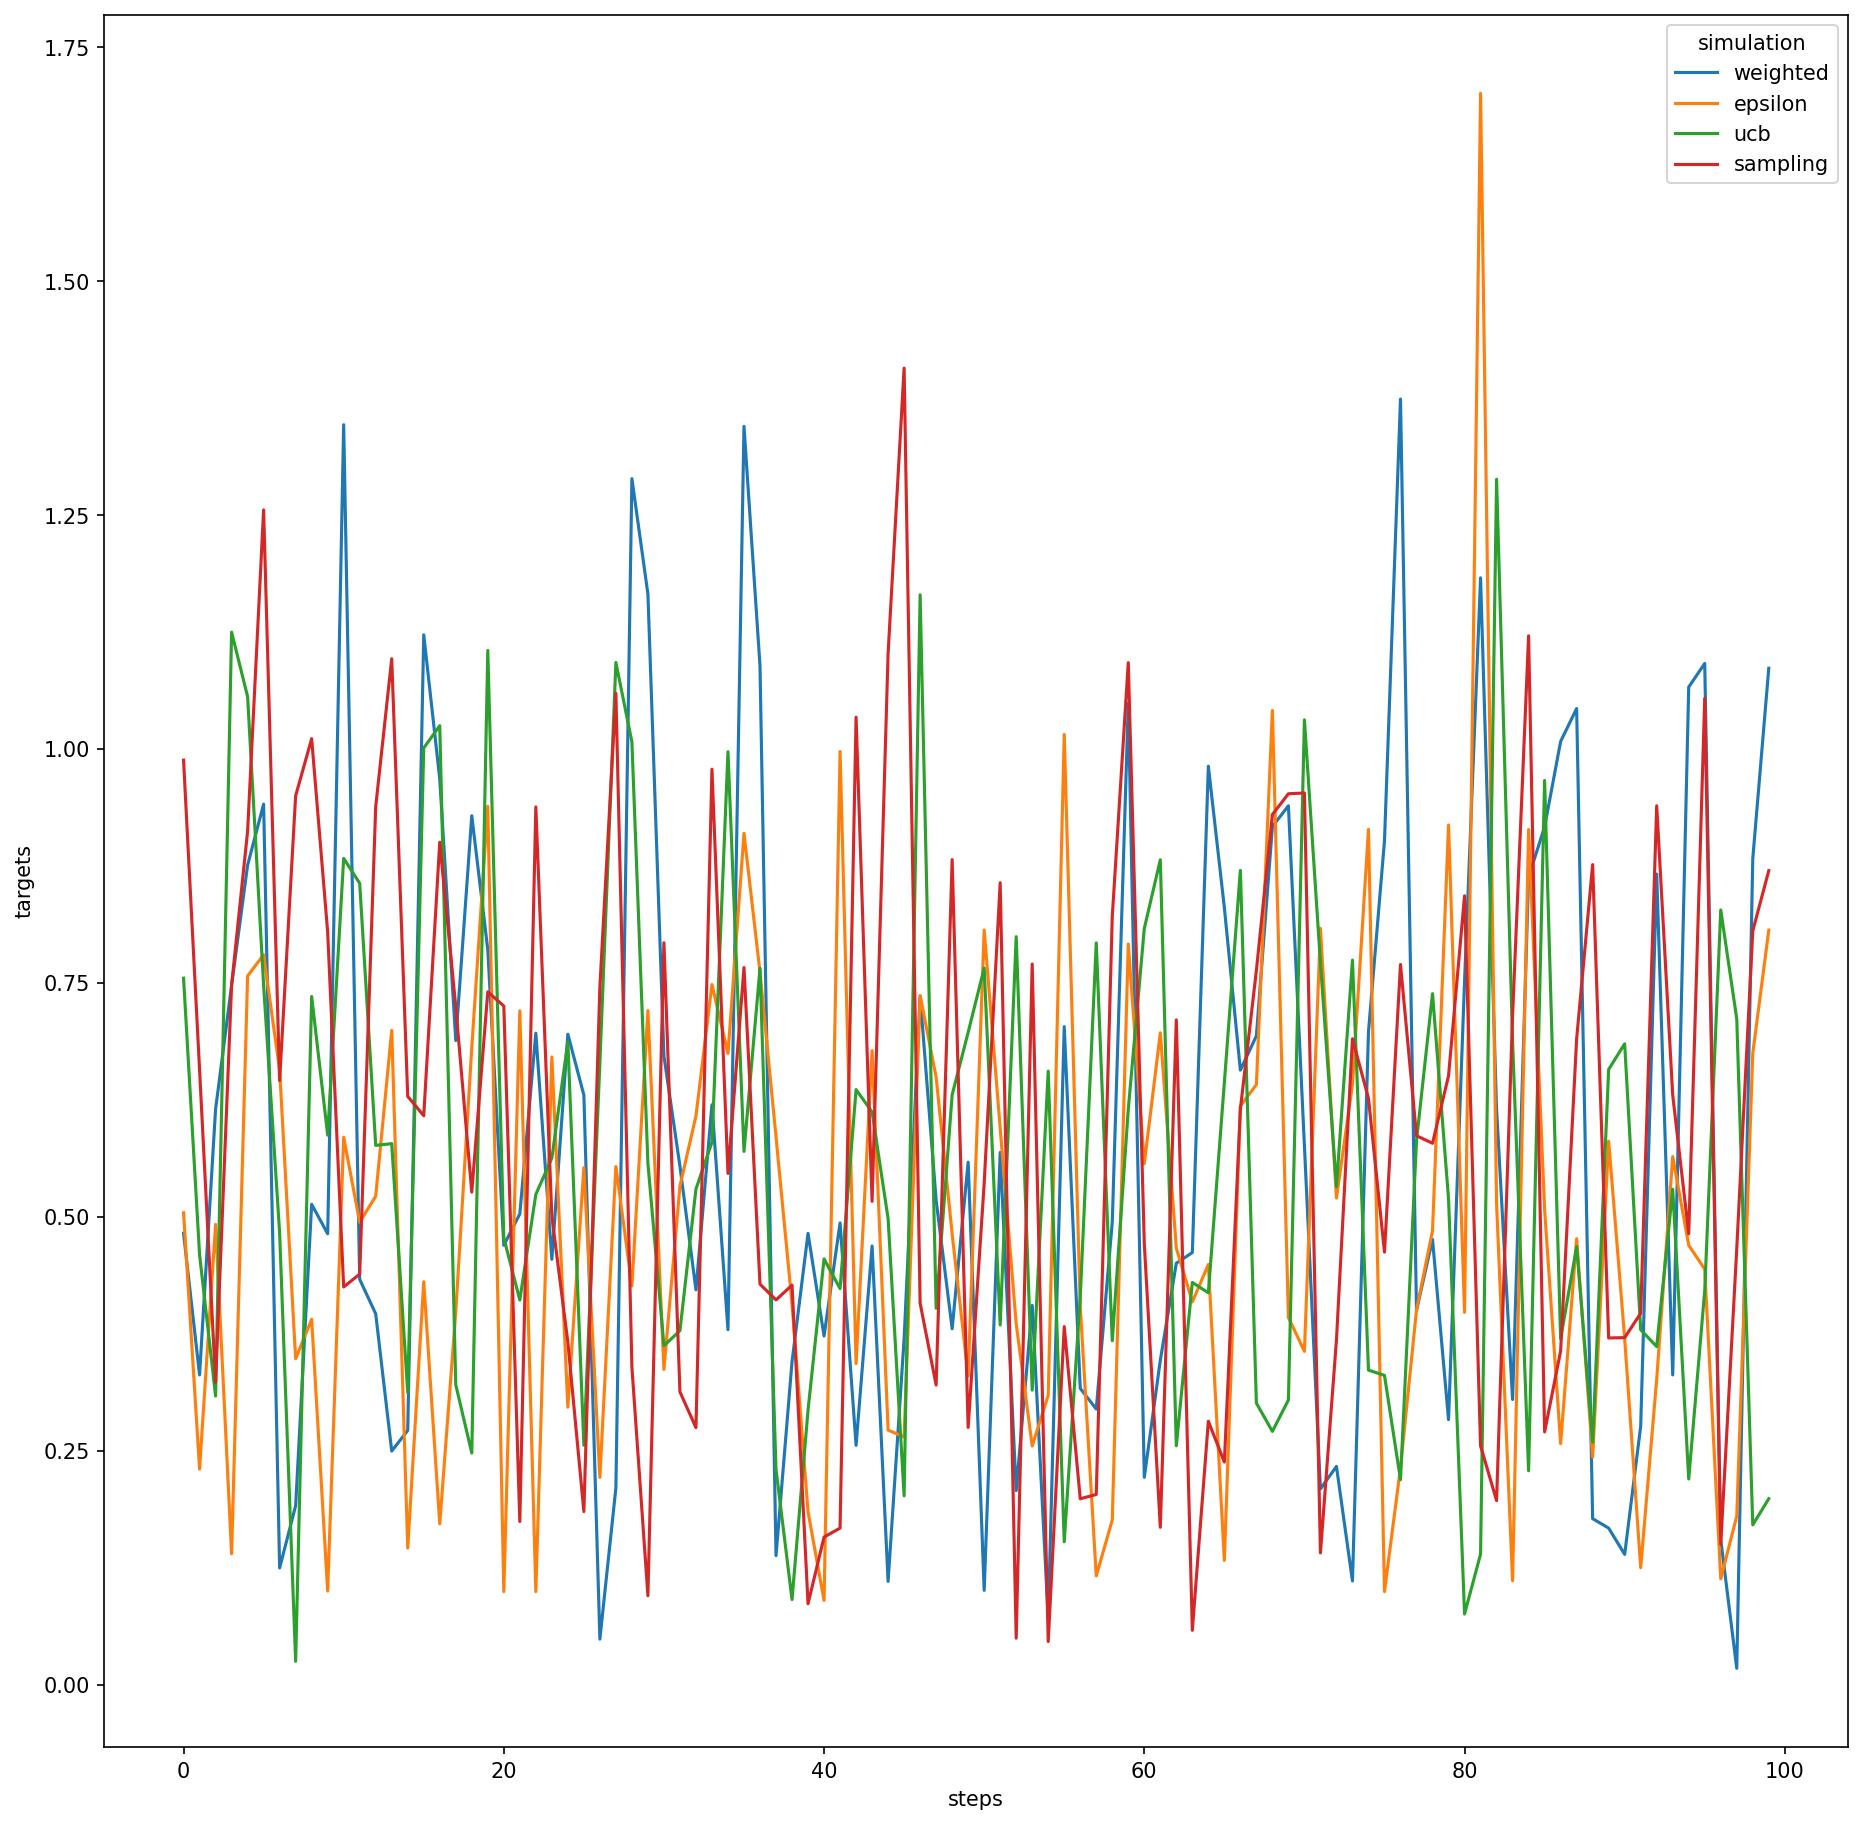

In [21]:
f = sns.lineplot(
    base_examples_df.loc[base_examples_df.steps < 100], 
    x='steps', 
    y='targets', 
    hue='simulation'
)

Since we know which distribution is best and these results are hard to interpret we will instead look at the number of times each solver called the right action

<Axes: xlabel='simulation', ylabel='count'>

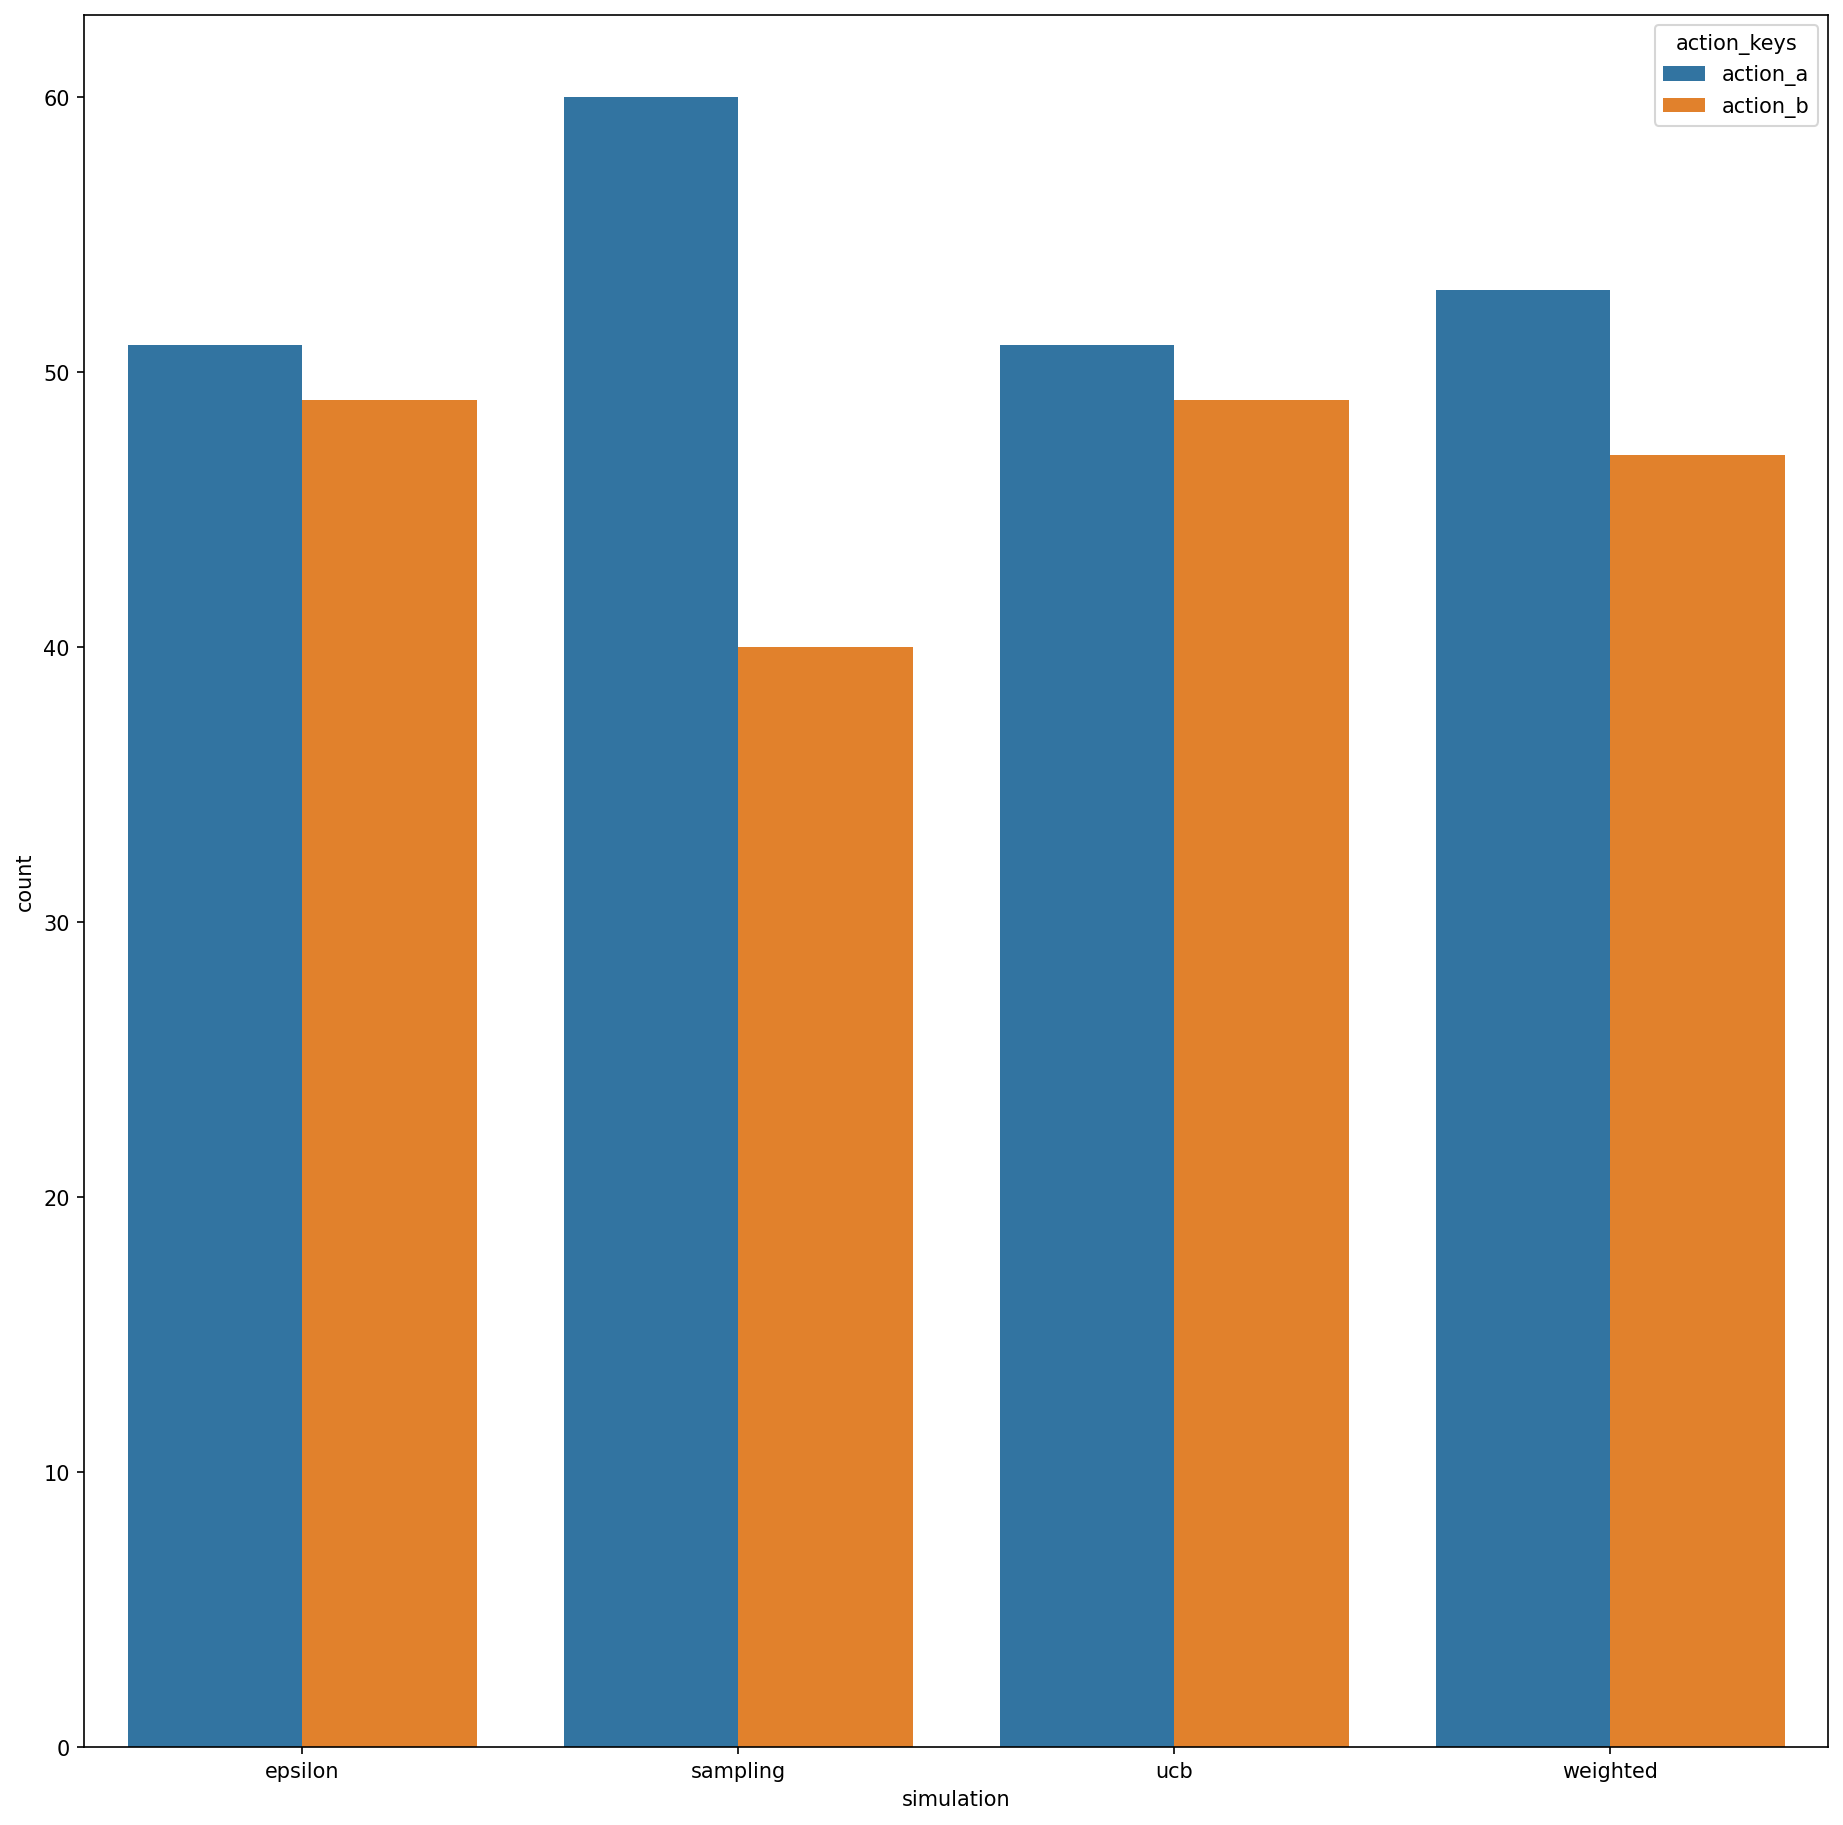

In [22]:
base_examples_action_count_df = (
    base_examples_df[['simulation', 'action_keys']]
    .groupby(['simulation', 'action_keys'])['action_keys']
    .count()
    .to_frame(name='count')
    .reset_index()
)

sns.barplot(
    base_examples_action_count_df,
    x='simulation',
    y='count',
    hue='action_keys'
)

We can see that in this context the better solver is the Sampling solver!

The next section will be about comparing performance of different solvers given different contexts
